<a href="https://colab.research.google.com/github/poojaojha-ai/AIHC-5010-Winter-2026/blob/main/01_Disease_Prevalence_Bernoulli_MLE_Updated_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIHC 5010

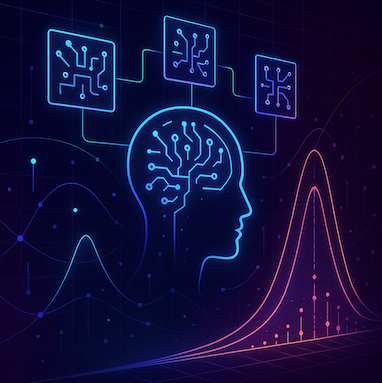


## Estimating Disease Prevalence with Probability and Maximum Likelihood  
### A Simple Model for Pneumonia in the Emergency Department

In this notebook we'll build **intuition for probability and Maximum Likelihood Estimation (MLE)** using a simple epidemiology-style story.

> Imagine we are studying patients arriving at the emergency department (ED) during flu season.  
> For each patient, we use a **gold-standard test** (e.g., CT, lab confirmation, expert consensus) to determine whether they have **pneumonia**.

We record a binary label for each patient:

- \(1\) = pneumonia present  
- \(0\) = no pneumonia

We assume the population we are sampling from has a fixed, but unknown, **prevalence** of pneumonia:

\begin{align}
p = \mathbb{P}(\text{a random ED patient has pneumonia})
\end{align}

Our goal:

- Use the observed sequence of \(0/1\) labels to estimate the **underlying prevalence** \(p\).
- See how this leads directly to the idea of a **likelihood function**, **maximum likelihood estimation**, and eventually **binary cross-entropy**.


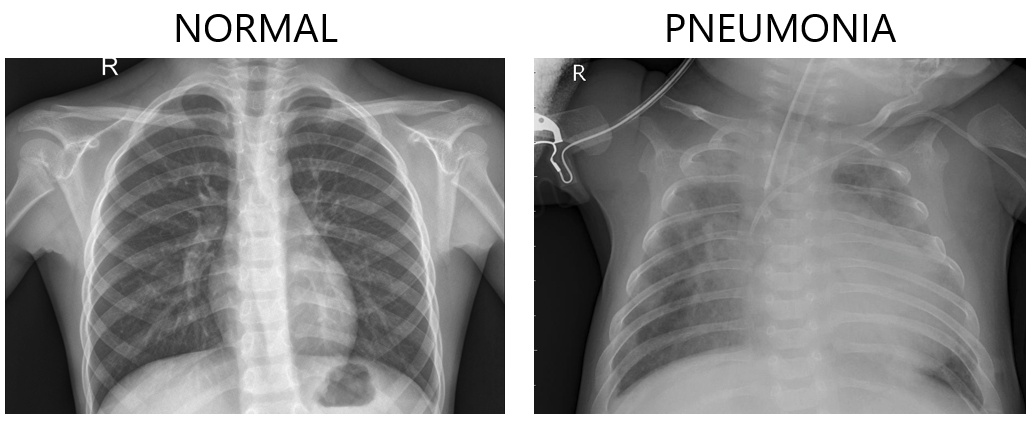

In [ ]:

# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import FloatSlider, IntSlider, Button, HBox, VBox, Output
from IPython.display import display

# Set a random seed
np.random.seed(42)



## 1. A simple model for disease presence

For each ED patient, we define a binary random variable \(X\):

- \(X = 1\) with probability \(p\): **pneumonia**
- \(X = 0\) with probability \(1-p\): **no pneumonia**

This is exactly a **Bernoulli random variable**.

If we observe \(n\) patients, we get a sequence:

\begin{align}
x_1, x_2, \dots, x_n, \quad x_i \in \{0, 1\}
\end{align}

We will estimate the unknown prevalence \(p\) from this observed data.


In [ ]:

def sample_patients(p: float, n: int) -> np.ndarray:
    """Simulate n ED patients (0=no pneumonia, 1=pneumonia) from a Bernoulli(p) model."""
    return np.random.binomial(1, p, size=n)


def summarize_labels(labels: np.ndarray):
    n = len(labels)
    num_pneumonia = labels.sum()
    num_normal = n - num_pneumonia
    p_hat = labels.mean()
    print(f"Total patients: {n}")
    print(f"  Pneumonia (1): {num_pneumonia}")
    print(f"  No pneumonia (0): {num_normal}")
    print(f"  Estimated prevalence (MLE): p̂ = {p_hat:.3f}")



### Interactive demo: sample patients and estimate prevalence

Use the sliders to choose:

- the **true prevalence** \(p\) of pneumonia in the ED,
- the **number of patients** \(n\) in your sample.

Then click the button to simulate the data and compute the **maximum likelihood estimate** of \(p\), which will turn out to be the **sample mean** of the labels.


In [ ]:

p_slider = FloatSlider(value=0.3, min=0.0, max=1.0, step=0.05, description='True p')
n_slider = IntSlider(value=20, min=5, max=200, step=5, description='N patients')
simulate_button = Button(description='Sample patients', button_style='primary')
out_sim = Output()

def on_simulate_clicked(b):
    with out_sim:
        out_sim.clear_output()
        p_true = p_slider.value
        n = n_slider.value
        labels = sample_patients(p_true, n)
        print(f"True prevalence p: {p_true:.2f}\n")
        summarize_labels(labels)

        # Plot histogram of labels
        fig, ax = plt.subplots()
        counts = [np.sum(labels == 0), np.sum(labels == 1)]
        ax.bar([0, 1], counts)
        ax.set_xticks([0, 1])
        ax.set_xlabel('Label (0=no pneumonia, 1=pneumonia)')
        ax.set_ylabel('Count')
        ax.set_title('Observed patient labels')
        plt.show()

simulate_button.on_click(on_simulate_clicked)
display(VBox([HBox([p_slider, n_slider, simulate_button]), out_sim]))



## 2. Synthetic "X-ray style" images for intuition

To keep things visually engaging, we can associate each patient with a **toy image** that loosely resembles a chest X-ray:

- **No pneumonia (0)**: mostly smooth background noise.
- **Pneumonia (1)**: noise **plus a brighter "lesion-like" patch**.

> These are **not real medical images** and are not meant for any diagnostic use — they are just simple visual aids.

The key point: the **math** for estimating prevalence \(p\) uses only the **labels**, not the images themselves.


In [ ]:

def generate_synthetic_cxr(label: int, size: int = 64) -> np.ndarray:
    """Generate a toy 'chest X-ray'-like image.

    label = 0 -> no pneumonia
    label = 1 -> pneumonia (add bright blob)
    """
    img = np.random.normal(loc=0.4, scale=0.08, size=(size, size))
    img = np.clip(img, 0.0, 1.0)

    if label == 1:
        # Add a bright circular-ish blob
        cx, cy = np.random.randint(size//3, 2*size//3, size=2)
        radius = size // 6
        y, x = np.ogrid[:size, :size]
        mask = (x - cx)**2 + (y - cy)**2 <= radius**2
        img[mask] += 0.4
        img = np.clip(img, 0.0, 1.0)
    return img


def generate_series_with_images(p: float, n: int, size: int = 64):
    labels = sample_patients(p, n)
    images = [generate_synthetic_cxr(int(lbl), size=size) for lbl in labels]
    return labels, images



### Interactive: sample patients with toy images

Use the slider to choose a true prevalence \(p\), and generate a **series of patients** with labels and synthetic images.

We'll show:

- The **first few images** in a grid.
- The corresponding **sequence of labels**.
- The **maximum likelihood estimate** \(\hat{p}\) from the labels.


In [ ]:

p_img_slider = FloatSlider(value=0.3, min=0.0, max=1.0, step=0.05, description='True p')
n_img_slider = IntSlider(value=16, min=4, max=64, step=4, description='N patients')
img_button = Button(description='Generate patients', button_style='primary')
out_img = Output()

def on_generate_images(b):
    with out_img:
        out_img.clear_output()
        p_true = p_img_slider.value
        n = n_img_slider.value

        labels, images = generate_series_with_images(p_true, n, size=64)
        p_hat = labels.mean()

        print(f"True prevalence p: {p_true:.2f}")
        print(f"Estimated p̂ (sample mean): {p_hat:.3f}\n")
        print("Label sequence (first 32):", labels[:32])

        # Show a grid of images (up to 16)
        num_show = min(n, 16)
        cols = 4
        rows = int(np.ceil(num_show / cols))
        fig, axes = plt.subplots(rows, cols, figsize=(8, 2*rows))
        axes = np.array(axes).reshape(rows, cols)

        for i in range(rows * cols):
            ax = axes[i // cols, i % cols]
            if i < num_show:
                ax.imshow(images[i])
                ax.set_title(f"y={labels[i]}" )
            ax.axis('off')
        plt.tight_layout()
        plt.show()

img_button.on_click(on_generate_images)
display(VBox([HBox([p_img_slider, n_img_slider, img_button]), out_img]))



## 3. Likelihood of a sequence of labels

Suppose we observe labels for \(n\) patients:

\begin{align}
x_1, x_2, \dots, x_n, \quad x_i \in \{0, 1\}
\end{align}

Given a candidate prevalence value \(p\), the probability of seeing **exactly that sequence** of labels is:

\begin{align}
L(p)
&= \prod_{i=1}^n p^{x_i} (1 - p)^{1 - x_i}
\end{align}

This function of \\(p\\) is called the **likelihood function**.

- For different values of \\(p\\), the likelihood changes.
- The **maximum likelihood estimate (MLE)** is the value of \\(p\\) that **maximises** this function.


In [ ]:

def bernoulli_log_likelihood(p: float, x: np.ndarray) -> float:
    """Compute log-likelihood of Bernoulli(p) for data x (0/1)."""
    p = np.clip(p, 1e-9, 1 - 1e-9)  # avoid log(0)
    return np.sum(x * np.log(p) + (1 - x) * np.log(1 - p))


def plot_likelihood_curve(x: np.ndarray):
    p_grid = np.linspace(0.001, 0.999, 200)
    logL = np.array([bernoulli_log_likelihood(p, x) for p in p_grid])

    # For plotting, rescale to relative likelihood in [0,1]
    relL = np.exp(logL - logL.max())
    p_hat = x.mean()

    fig, ax = plt.subplots()
    ax.plot(p_grid, relL)
    ax.axvline(p_hat, linestyle='--')
    ax.set_xlabel('p (pneumonia prevalence)')
    ax.set_ylabel('Relative likelihood (rescaled)')
    ax.set_title('Likelihood of observed labels as a function of p')
    ax.text(p_hat, 0.05, f'p̂ = {p_hat:.2f}', rotation=90, va='bottom')
    plt.show()



### Interactive: likelihood curve for your sample

1. Choose a true prevalence \(p\) and sample size \(n\).  
2. Simulate a dataset of patient labels.  
3. Visualise the likelihood curve and see where it peaks.


In [ ]:

p_like_slider = FloatSlider(value=0.3, min=0.0, max=1.0, step=0.05, description='True p')
n_like_slider = IntSlider(value=20, min=5, max=100, step=5, description='N patients')
like_button = Button(description='Sample & plot likelihood', button_style='primary')
out_like = Output()

def on_likelihood_clicked(b):
    with out_like:
        out_like.clear_output()
        p_true = p_like_slider.value
        n = n_like_slider.value
        x = sample_patients(p_true, n)
        print(f"True prevalence p: {p_true:.2f}")
        summarize_labels(x)
        plot_likelihood_curve(x)

like_button.on_click(on_likelihood_clicked)
display(VBox([HBox([p_like_slider, n_like_slider, like_button]), out_like]))



## 4. Solving the MLE analytically

From the likelihood

\begin{align}
L(p) = \prod_{i=1}^n p^{x_i} (1 - p)^{1 - x_i},
\end{align}

we often work with the **log-likelihood** (easier to differentiate):

\begin{align}
\hat{p} = \operatorname*{argmax}_{p} L = \operatorname*{argmax}_{p} \prod_{i=1}^n p^{x_i} (1 - p)^{1 - x_i} = \operatorname*{argmax}_{p} \sum_{i=1}^n \big[ x_i \log p + (1 - x_i) \log(1 - p) \big].
\end{align}

To find the MLE, we **take the derivative**, set it to zero, and solve:

\begin{align}
\frac{d\ell}{dp} = 0.
\end{align}

Simplifying, this ultimately gives:

\begin{align}
\hat{p} = \frac{1}{n} \sum_{i=1}^n x_i,
\end{align}

i.e. the **sample mean of the labels** — exactly the empirical estimate of disease prevalence we found above.



## 5. Connection to binary cross-entropy (foreshadowing)

If we **flip the sign** of the log-likelihood and **average** over \(n\), we obtain the loss

\begin{align}
\mathcal{L}(p)
= -\frac{1}{n}\,\ell(p)
= -\frac{1}{n} \sum_{i=1}^n \Big[ x_i \log p + (1 - x_i)\,\log\big(1 - p\big) \Big].
\end{align}

This is exactly the **binary cross-entropy loss** used to train many classification models when they output a single probability \(p\) for the positive class.

In more general models, the probability may depend on patient features ($z_i$) and parameters ($\theta$):

\begin{align}
\hat{p}_i = p_\theta(x_i = 1 \mid z_i).
\end{align}

The loss then becomes

\begin{align}
\mathcal{L}(\theta)
= -\frac{1}{n} \sum_{i=1}^n \Big[ x_i \log \hat{p}_i + (1 - x_i) \log(1 - \hat{p}_i) \Big],
\end{align}

which is the standard **binary cross-entropy** used in logistic regression and neural networks.

The key point: **binary cross-entropy is just negative average log-likelihood** for Bernoulli data.



## 6. Summary

- We model **pneumonia prevalence** in ED patients as a Bernoulli random variable with unknown parameter \(p\).
- Given observed labels \(x_1, \dots, x_n\), the **likelihood function** is
\begin{align}
  L(p) = \prod_{i=1}^n p^{x_i} (1 - p)^{1 - x_i}.
\end{align}
- The **maximum likelihood estimate** of \(p\) is the **sample mean**:
\begin{align}
  \hat{p} = \frac{1}{n} \sum_{i=1}^n x_i.
\end{align}
- Taking **negative average log-likelihood** yields the familiar **binary cross-entropy** loss.
- The same idea scales up to complex models that estimate (p) for high-dimensional inputs \(z\), using cross-entropy as the training objective.

In other words, from simple prevalence estimation all the way to deep learning models, we are always doing some form of **maximum likelihood estimation**.


# Question: If MLE is just sample mean... why did we make this so complicated???

Short answer: in **this one toy case**, MLE *happens* to be the sample mean.  
In almost every problem you actually care about, it isn’t that simple, **but the same MLE machinery still works.**

A few concrete reasons we still “make it complicated”:

## This example is like the hello-world of likelihoods

For a Bernoulli distribution with unknown \(p\):

\begin{align}
\hat p_{\text{MLE}} = \frac{1}{n}\sum_{i=1}^n x_i
\end{align}

That’s wonderfully simple, but it’s also a huge exception:

- For a **Gaussian** with unknown mean and variance, MLE gives:
  - $(\hat\mu = \text{sample mean})$
  - $(\hat\sigma^2 = \text{sample variance (with }1/n\text{, not }1/(n-1)\text{)})$
- For a **Poisson**, the MLE of the rate ($\lambda$) is also the sample mean.
- For most real models (logistic regression, neural nets, LLMs, etc.), there’s **no closed-form** solution at all, you only have the likelihood and do gradient descent.

Learning the MLE framework on the easy Bernoulli case gives you a tool you can apply when the answer *isn’t* the sample mean.

## It tells you *why* the sample mean is a good estimator

If you didn’t go through the likelihood:

- “Use the mean” is just a heuristic.

With MLE, you can say:

> The mean is the parameter that makes the observed data **most probable** under the model.

That buys you:

- A principled justification (not just intuition).
- Access to all the theory that comes with MLE: consistency, asymptotic normality, approximate confidence intervals, likelihood ratio tests, etc.

## It’s the bridge to loss functions and deep learning

The same derivation you just did:

\begin{align}
\ell(p) = \sum_{i=1}^n \big[ x_i \log p + (1-x_i)\log(1-p) \big]
\end{align}

→ negative average log-likelihood:

\begin{align}
\mathcal L(p) = -\frac{1}{n}\,\ell(p)
\end{align}

is **exactly** the binary cross-entropy loss you use for:

- logistic regression,
- medical image classifiers,
- “pneumonia vs normal” CNNs,
- and token prediction in LLMs (in the multi-class version).

So the “complication” isn’t just about this toy Bernoulli; it’s giving you a template:

> **Model = probability distribution → write down likelihood → take log →  
> minimize negative log-likelihood → that’s your loss.**

That’s most of modern ML training.

## Once you leave the unconditional Bernoulli, the mean isn’t enough

As soon as you say things like:

- “I want $p(\text{pneumonia} \mid \text{age, vitals, image})\$,” or  
- “I want a distribution over next tokens given a context,”

you’re in the world of:

\begin{align}
p_\theta(y \mid x), \quad \theta \in \mathbb{R}^d
\end{align}

Now it’s no longer “estimate a single \(p\) with the sample mean.” You need:

- A way to define what “best” means → **maximum likelihood**.
- A loss to optimize → **negative log-likelihood / cross-entropy**.
- Optimization methods (e.g. gradient descent) to find $\theta$.

The Bernoulli/sample-mean example is just the **baby version** of this general story.

## Why bother, then?

Yes, for this specific toy prevalence problem, you *could* just say:

> “The answer is the sample mean.”

But walking through MLE:

- shows *why* the mean appears,
- gives a reusable recipe for more complex models,
- and connects directly to the loss functions you actually use in modern AI.

The “complication” is basically the **scaffolding** that lets you go from  
“mean of 0/1 labels” to “training an AI model with cross-entropy.”
